# Introduction

This competition is about modelling whether a pair of questions on Quora is asking the same question. For this problem we have about 400,000 training examples. Each row consists of two sentences and a binary label that indicates to us whether the two questions were the same or not.

Inspired by a nice kernel from Anisotropic I've added a few interactive 2D and 3D scatter plots. To get an insight into how the duplicates evolve over the number of words in the questions, I've added a plotly animation that encodes number of words and word share similarity in a scatter plot.


**We will be looking in detail at:**

- question pair TF-IDF encodings
- basic feature engineering and their embeddings in lower - - dimensional spaces
- parallel coordinates visualization
- model selection and evaluation + sample submission

We will look at standard binary classification metrics, like ROC and PR curves and their AUCs. The best (linear) model that we found then generates a submission.

**Credit to [philschmidt](https://www.kaggle.com/philschmidt/quora-eda-model-selection-roc-pr-plots) on kaggle**

# Download Data

In [ ]:
!pip install kaggle

In [ ]:
# Upload your kaggle api key
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 66 bytes


In [ ]:
!rm -r data/
!mkdir data/

rm: cannot remove 'data/': No such file or directory


In [ ]:
!kaggle competitions download quora-question-pairs

 98% 170M/173M [00:01<00:00, 127MB/s]
100% 173M/173M [00:01<00:00, 120MB/s]
test.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
  0% 0.00/4.95M [00:00<?, ?B/s]
100% 4.95M/4.95M [00:00<00:00, 80.1MB/s]
 24% 5.00M/21.2M [00:00<00:00, 33.8MB/s]
100% 21.2M/21.2M [00:00<00:00, 84.0MB/s]


In [ ]:
!unzip test.csv.zip

Archive:  test.csv.zip
  inflating: test.csv                


In [ ]:
!unzip train.csv.zip

Archive:  train.csv.zip
  inflating: train.csv               


In [ ]:
!mv train.csv test.csv data/

In [ ]:
!rm sample_submission.csv.zip test.csv.zip train.csv.zip

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
import os

%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer
from sklearn.manifold import TSNE

In [ ]:
i = 0
for dirname, _, filenames in os.walk('./data'):
  for filename in filenames:
    i+=1
    print(os.path.join(dirname, filename))
print(i, "files")

./data/train.csv
./data/test.csv
2 files


In [ ]:
df = pd.read_csv("./data/train.csv").fillna("")

# Basic data exploration

In [ ]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


So we have six columns in total one of which is the label.



In [ ]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404290 non-null  object
 4   question2     404290 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [ ]:
df.shape


(404290, 6)

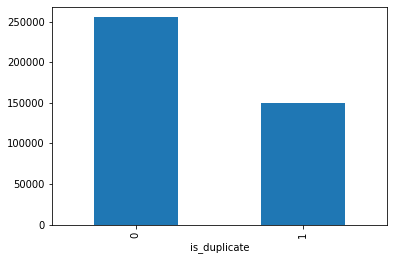

In [ ]:
df.groupby("is_duplicate")["id"].count().plot.bar()

So about 62.5% are not duplicates and the rest are

# Feature Construction

We will now construct a basic set of features that we will later use to embed our samples with.

The first we will be looking at is rather standard TF-IDF encoding for each of the questions. In order to limit the computational complexity and storage requirements we will only encode the top terms across all documents with TF-IDF and also look at a subsample of the data.

From wikipedia: tf-idf (term frequency–inverse document frequency) encoding is a numerical statistic that is intended to reflect how important a word is to a document in a corpus.

**Term frequency**: # of times word occurs in a document (sentence in this case)

- tf(t,d) = freq(t,d) / SUM f(t',d) for all t' in d

**Inverse Document Frequency**: diminishes the weight of terms that occur very frequently in the document set and increases the weight of terms that occur rarely. Some examples of words we don't want to emphasize are the, a, is, etc.

- idf(t,d) = log( N / d ) 

 N = number of documents in corpus
 
 d = number of documents where the term {t appears

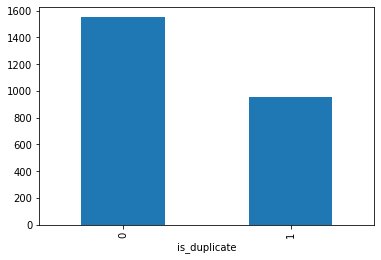

In [ ]:
dfs = df[0:2500]
dfs.groupby("is_duplicate")['id'].count().plot.bar()

The subsample still has a very similar label distribution so it's ok to continue without taking a deeper look to achieve better sampling (better than just taking the first rows of the dataset).

Create a dataframe where the top 50% of rows have only question 1 and the bottom 50% have only question 2, same ordering per halve as in the original dataframe.

In [ ]:
dfq1, dfq2 = dfs[['qid1', 'question1']], dfs[['qid2', 'question2']]
dfq1.columns = ['qid1', 'question']
dfq2.columns = ['qid2', 'question']

# merge two two dfs, nans for question(x)
dfqa = pd.concat((dfq1, dfq2), axis=0).fillna("")
nrows_for_q1 = dfqa.shape[0]/2
dfqa.shape

(5000, 3)

Transform questions by TF-IDF.



In [ ]:
mq1 = TfidfVectorizer(max_features=256).fit_transform(dfqa['question'].values)
mq1[0]

<1x256 sparse matrix of type '<class 'numpy.float64'>'
	with 7 stored elements in Compressed Sparse Row format>

Since we are looking at pairs of data, we will be taking the difference of all question one and question two pairs with this. This will result in a matrix that again has the same number of rows as the subsampled data and one vector that describes the relationship between the two questions.

In [ ]:
diff_encodings = np.abs(mq1[::2] - mq1[1::2])
diff_encodings

<2500x256 sparse matrix of type '<class 'numpy.float64'>'
	with 29265 stored elements in Compressed Sparse Row format>

# 3D t-SNE embedding

We will use t-SNE to embed the TF-IDF vectors in three dimensions and create an interactive scatter plot with them.



In [ ]:
tsne = TSNE(
    n_components=3, # number of dimensions to reduce to
    init='random', # pca is another option
    random_state=101, # random seed,
    method='barnes_hut',
    n_iter=250,
    verbose=2,
    angle=0.5
).fit_transform(diff_encodings.toarray())

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2500 samples in 0.063s...
[t-SNE] Computed neighbors for 2500 samples in 2.985s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2500
[t-SNE] Computed conditional probabilities for sample 2000 / 2500
[t-SNE] Computed conditional probabilities for sample 2500 / 2500
[t-SNE] Mean sigma: 0.466897
[t-SNE] Computed conditional probabilities in 0.137s
[t-SNE] Iteration 50: error = 119.4314499, gradient norm = 0.0704645 (50 iterations in 10.859s)
[t-SNE] Iteration 100: error = 125.5855103, gradient norm = 0.0461752 (50 iterations in 11.246s)
[t-SNE] Iteration 150: error = 131.3215942, gradient norm = 0.0273864 (50 iterations in 9.162s)
[t-SNE] Iteration 200: error = 139.4113007, gradient norm = 0.0273477 (50 iterations in 9.300s)
[t-SNE] Iteration 250: error = 141.8252869, gradient norm = 0.0287275 (50 iterations in 9.635s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 141.825287
[t-SNE] KL divergen